# Importing Libraries

We use a plethora of libraries for our task at hand ranging from libraries for data preprocessing, transformation, visualization, analysis, modelling and especially for interpreting and working with musical data

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import glob
from music21 import converter, instrument, note, chord, stream
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
import nltk
import random
import math
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

# Preprocessing

The dataset we are using is from a game called Final Fantasy VII and we are using the piano instrument sounds to be able to generate new piano instrument sounds.

We are using the .midi file format as it presents us with an easy interface for extracting all the nodes and chords present in each sound file.

So we extract all the piano notes and chords from all files and store them together in a notes list sequence. To save time we also store these notes in a pickle object file for easy access in subsequent runs.

We also go ahead and define various utility functions such as applying laplace smoothing for probabilistic models, perplexity for probabilistic models as a metric for comparision between different models.

Moreover, since we are using a music based data set, we also need to define some new metrics which take the context as music instead of completely treating it as a natural language.

So, we use a time vs pitch graph to figure out how the generated notes vary over a period of time to ensure there is no observant continuity breaks or inconsistency to break the melody.

We also use comparision between the generated chord sequences and the chord sequences that originally existed in the data to see how many patterns the model is able to learn and adapt to.

In [ ]:
notes = []

for file in glob.glob("gdrive/MyDrive/Music Gen/data/*.mid"):
    midi = converter.parse(file)
    notes_to_parse = None

    parts = instrument.partitionByInstrument(midi)

    if parts:
        notes_to_parse = parts.parts[0].recurse()
    else:
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append(".".join(str(n) for n in element.normalOrder))

In [ ]:
with open ("gdrive/MyDrive/Music Gen/artifacts/notes", "rb") as fp:
    notes = pickle.load(fp)

In [ ]:
n_vocab = len(set(notes))

def laplace_smooth(n_gram, n_count, n_gram_prev, n_gram_prev_count):
    m_count = n_gram_prev_count[n_gram_prev]
    return (n_count + 1) / (m_count + 1 * n_vocab)

def perplexity(notes, grams, n_gram_model):
    n_grams = nltk.ngrams(notes, grams)
    probabilities = [n_gram_model[n_gram] for n_gram in n_grams]
    return math.exp((-1/len(notes)) * sum(map(math.log, probabilities)))

def plot_pitch_time(audio_file):
    y, sr = librosa.load(audio_file)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = pitches.mean(axis=0)
    time = np.arange(len(pitch_mean)) * librosa.frames_to_time(1, sr=sr)
    plt.figure(figsize=(12, 6))
    plt.plot(time, pitch_mean, label='Pitch (Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch (Hz)')
    plt.title('Pitch vs. Time')
    plt.legend()
    plt.show()

def get_common_chord_progressions(prediction_output):
    output_chords = list(filter(lambda x: '.' in x, prediction_output))
    output_three_chord_progressions = nltk.ngrams(output_chords, 3)
    output_three_chord_progressions_count = nltk.FreqDist(output_three_chord_progressions)

    print(f"Unique three chord progressions: {len(output_three_chord_progressions_count)}")

    output_four_chord_progressions = nltk.ngrams(output_chords, 4)
    output_four_chord_progressions_count = nltk.FreqDist(output_four_chord_progressions)

    print(f"Unique four chord progressions: {len(output_four_chord_progressions_count)}")
    print()

    for progression, count in output_three_chord_progressions_count.items():
        if progression in dict(three_chord_progressions_count):
            print(progression, count, dict(three_chord_progressions_count)[progression])
    print()
    for progression, count in output_four_chord_progressions_count.items():
        if progression in dict(four_chord_progressions_count):
            print(progression, count, dict(four_chord_progressions_count)[progression])

print(n_vocab)

352


# EDA

We analyze and find what all notes and chords are present in the dataset as well as what the most frequently appearing ones are.

Along with finding out the chord sequences in the orignal dataset, we are only considering 3 length or 4 length sequences are they are the most important ones in a majority of melodies.

In [ ]:
len(notes), notes[0], notes[1], len(set(notes))

(57177, '4.9', 'E2', 352)

<BarContainer object of 20 artists>

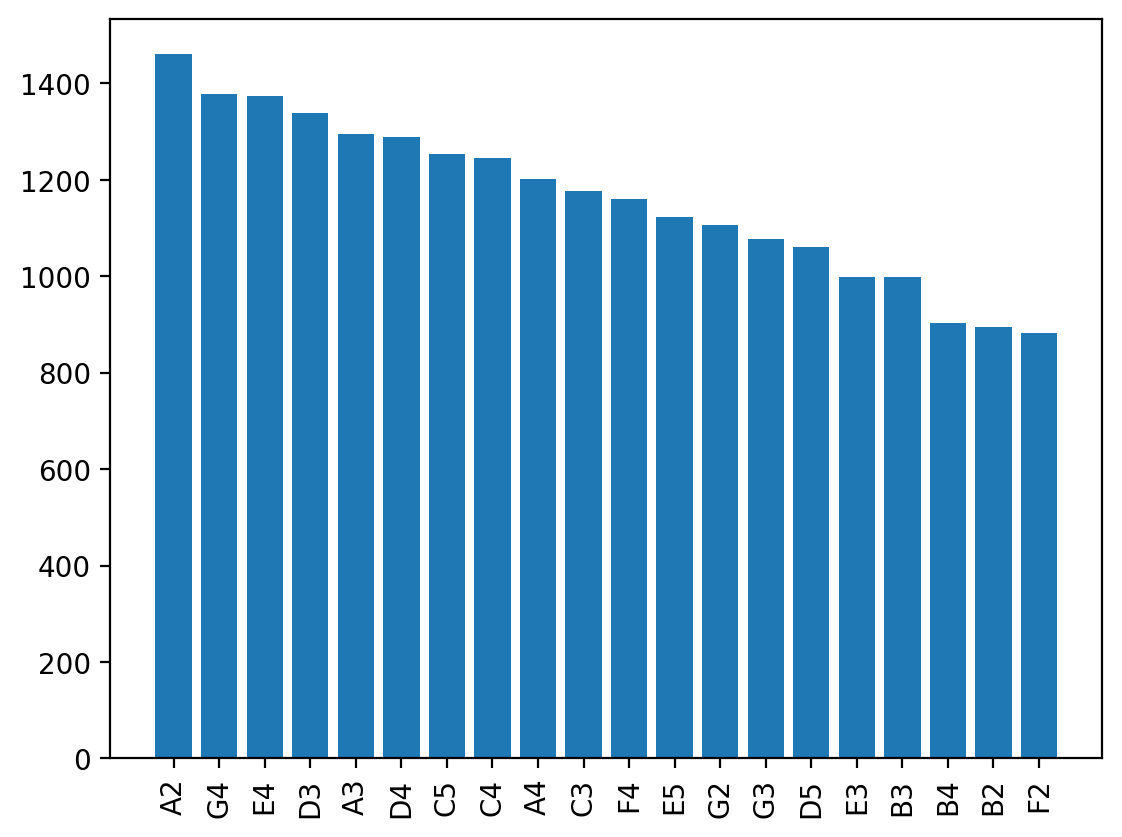

In [ ]:
notes_freq = dict(sorted(dict(collections.Counter(notes)).items(), key=lambda x: (x[1], x[0]), reverse=True)[:20])
plt.xticks(rotation = 90)
plt.bar(notes_freq.keys(), notes_freq.values())

<BarContainer object of 20 artists>

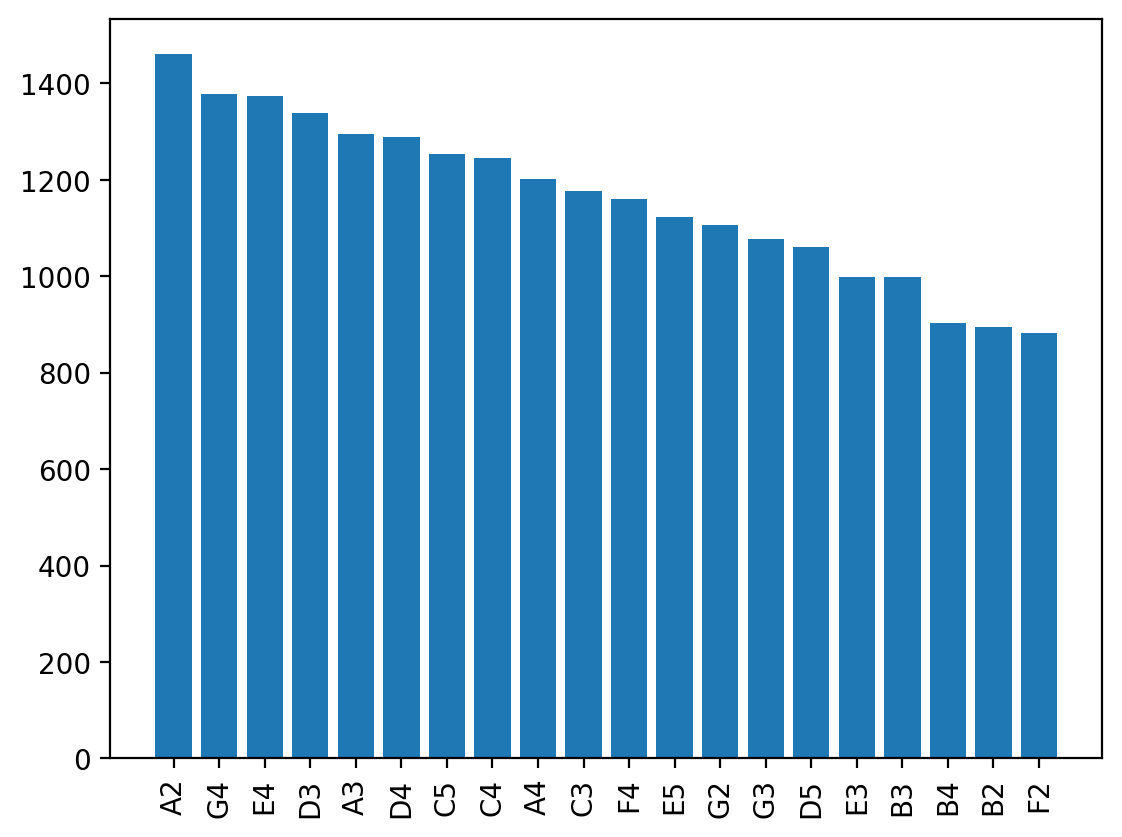

In [ ]:
tempn = list(filter(lambda x: '.' not in x, list((notes))))
tempn_freq = dict(sorted(dict(collections.Counter(tempn)).items(), key=lambda x: (x[1], x[0]), reverse=True)[:20])
plt.xticks(rotation = 90)
plt.bar(tempn_freq.keys(), tempn_freq.values())

<BarContainer object of 20 artists>

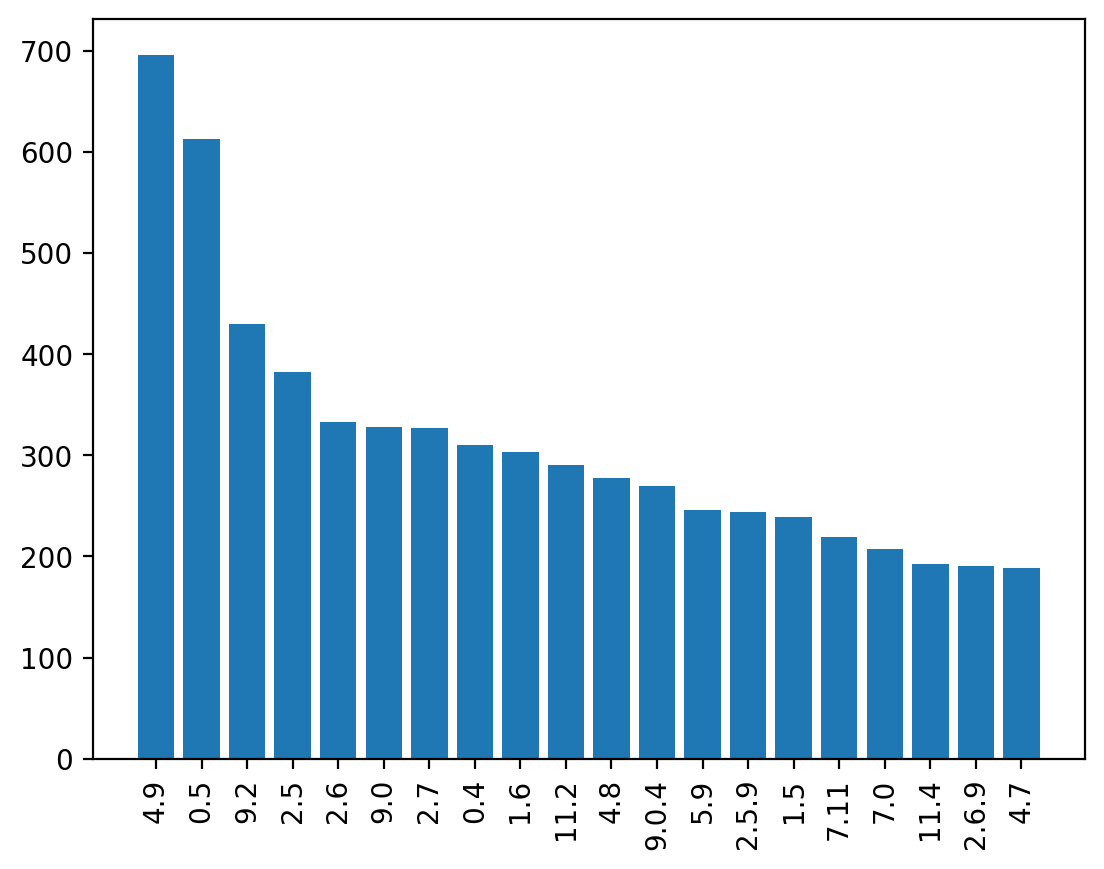

In [ ]:
tempc = list(filter(lambda x: '.' in x, list((notes))))
tempc_freq = dict(sorted(dict(collections.Counter(tempc)).items(), key=lambda x: (x[1], x[0]), reverse=True)[:20])
plt.xticks(rotation = 90)
plt.bar(tempc_freq.keys(), tempc_freq.values())

<BarContainer object of 20 artists>

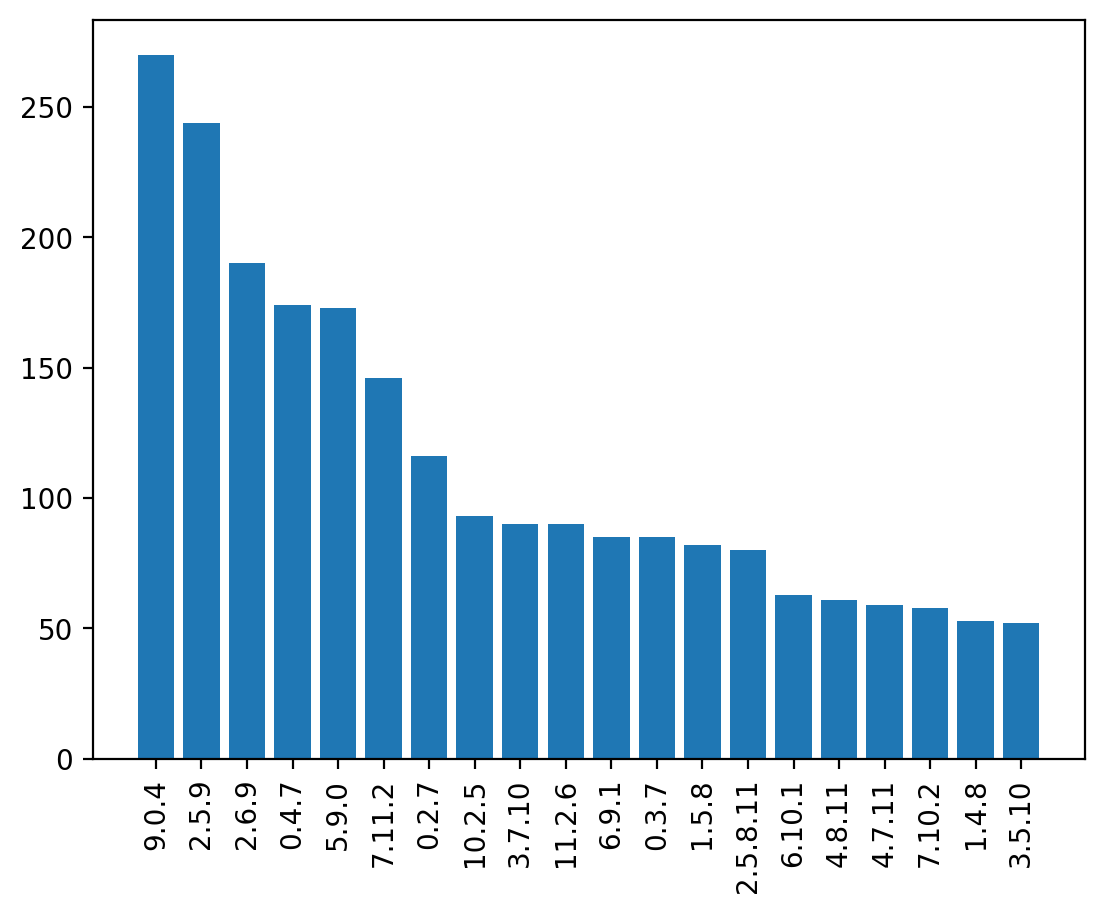

In [ ]:
tempc2 = list(filter(lambda x: len(x.split('.')) > 2, list((notes))))
tempc2_freq = dict(sorted(dict(collections.Counter(tempc2)).items(), key=lambda x: (x[1], x[0]), reverse=True)[:20])
plt.xticks(rotation = 90)
plt.bar(tempc2_freq.keys(), tempc2_freq.values())

In [ ]:
len(tempc)

12540

In [ ]:
three_chord_progressions = nltk.ngrams(tempc, 3)
three_chord_progressions_count = nltk.FreqDist(three_chord_progressions)

three_chord_progressions_count

FreqDist({('4.9', '4.9', '4.9'): 260, ('4.8', '4.8', '4.8'): 158, ('0.5', '0.5', '0.5'): 157, ('1.6', '1.6', '1.6'): 105, ('2.7', '2.7', '2.7'): 99, ('1.5', '1.5', '1.5'): 84, ('2.6', '2.6', '2.6'): 83, ('9.2', '9.2', '9.2'): 52, ('5.9', '5.9', '5.9'): 51, ('2.5.9', '2.5.9', '2.5.9'): 51, ...})

In [ ]:
four_chord_progressions = nltk.ngrams(tempc, 4)
four_chord_progressions_count = nltk.FreqDist(four_chord_progressions)

four_chord_progressions_count

FreqDist({('4.9', '4.9', '4.9', '4.9'): 184, ('4.8', '4.8', '4.8', '4.8'): 133, ('0.5', '0.5', '0.5', '0.5'): 98, ('1.6', '1.6', '1.6', '1.6'): 98, ('2.7', '2.7', '2.7', '2.7'): 81, ('2.6', '2.6', '2.6', '2.6'): 68, ('1.5', '1.5', '1.5', '1.5'): 43, ('11.1.5', '1.5', '1.5', '1.5'): 38, ('9.2', '9.2', '9.2', '9.2'): 37, ('5.9', '5.9', '5.9', '5.9'): 36, ...})

# Bigram

The bigram results are not that impressive since the next note depends completely on the previous one, so given that repetitions exist in music, it gets stuck in a loop of generating the same infinite sequence and hence doesn't has a good frequency-time graph, neither learns any chord sequences but has good perplexity since it has less choices.

In [ ]:
bigrams = nltk.ngrams(notes, 2)
bigrams_count = nltk.FreqDist(bigrams)

bigrams_prev = nltk.ngrams(notes, 1)
bigrams_prev_count = nltk.FreqDist(bigrams_prev)

In [ ]:
bigram_model = {bigram: laplace_smooth(bigram, bigram_count, bigram[:-1], bigrams_prev_count) for bigram, bigram_count in bigrams_count.items()}

In [ ]:
start = random.choice(list(dict(bigrams_prev_count.items()).keys()))

pattern = [*start]
prediction_output = []

for note_index in range(500):
    candidates = [[bigram[-1], prob] for bigram, prob in bigram_model.items() if list(bigram[:-1]) == pattern]
    candidates = sorted(candidates, key=lambda candidate: candidate[1], reverse=True)
    if len(candidates) == 0:
        start = random.choice(list(dict(bigrams_prev_count.items()).keys()))
        pattern = [*start]
        result = pattern[-1]
    else:
        result = candidates[0][0]
    prediction_output.append(result)
    pattern.append(result)
    pattern = pattern[1:]

In [ ]:
offset = 0
output_notes = []

for pattern in prediction_output:
    if ("." in pattern) or (pattern.isdigit()):
        notes_in_chord = pattern.split('.')
        new_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            new_notes.append(new_note)
        new_chord = chord.Chord(new_notes)
        new_chord.offset = offset
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    offset += 0.5

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp="gdrive/MyDrive/Music Gen/test_output_bigram.mid")

'gdrive/MyDrive/Music Gen/test_output_bigram.mid'

In [ ]:
perplexity(notes, 2, dict(bigrams_count.items()))

0.0686802298307916

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=256
  warnings.warn(


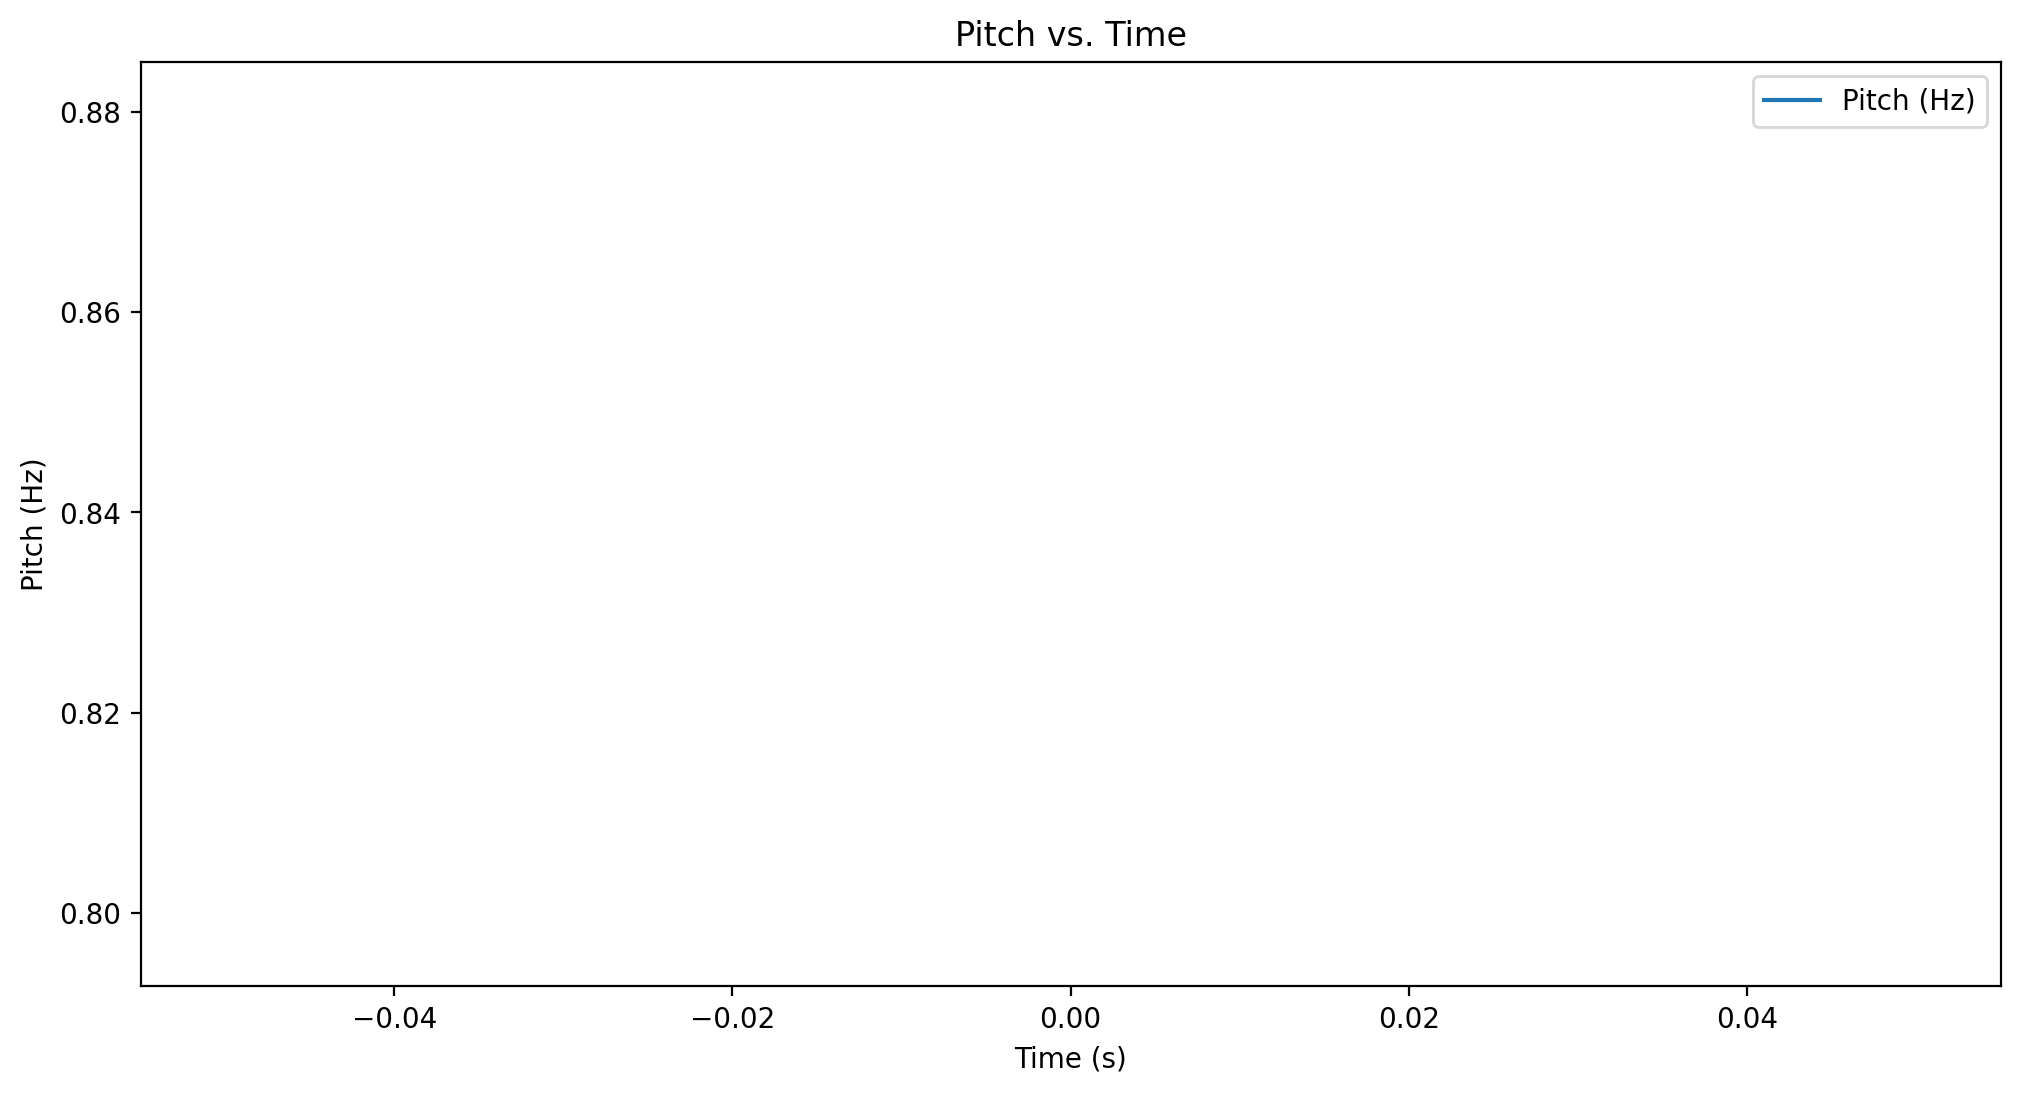

In [ ]:
plot_pitch_time("gdrive/MyDrive/Music Gen/test_output_bigram.wav")

In [ ]:
get_common_chord_progressions(prediction_output)

# Trigram

Improvement over the bigram, but still gets stuck with the same problem of infinite sequence generation, slightly better graph and chord sequences, worse perplexity since choices increase.

In [ ]:
trigrams = nltk.ngrams(notes, 3)
trigrams_count = nltk.FreqDist(trigrams)

trigrams_prev = nltk.ngrams(notes, 2)
trigrams_prev_count = nltk.FreqDist(trigrams_prev)

In [ ]:
trigram_model = {trigram: laplace_smooth(trigram, trigram_count, trigram[:-1], trigrams_prev_count) for trigram, trigram_count in trigrams_count.items()}

In [ ]:
start = random.choice(list(dict(trigrams_prev_count.items()).keys()))

pattern = [*start]
prediction_output = []

for note_index in range(500):
    candidates = [[trigram[-1], prob] for trigram, prob in trigram_model.items() if list(trigram[:-1]) == pattern]
    candidates = sorted(candidates, key=lambda candidate: candidate[1], reverse=True)
    if len(candidates) == 0:
        start = random.choice(list(dict(trigrams_prev_count.items()).keys()))
        pattern = [*start]
        result = pattern[-1]
    else:
        result = candidates[0][0]
    prediction_output.append(result)
    pattern.append(result)
    pattern = pattern[1:]

In [ ]:
offset = 0
output_notes = []

for pattern in prediction_output:
    if ("." in pattern) or (pattern.isdigit()):
        notes_in_chord = pattern.split('.')
        new_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            new_notes.append(new_note)
        new_chord = chord.Chord(new_notes)
        new_chord.offset = offset
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    offset += 0.5

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp="gdrive/MyDrive/Music Gen/test_output_trigram.mid")

'gdrive/MyDrive/Music Gen/test_output_trigram.mid'

In [ ]:
perplexity(notes, 3, dict(trigrams_count.items()))

0.26302884593663156

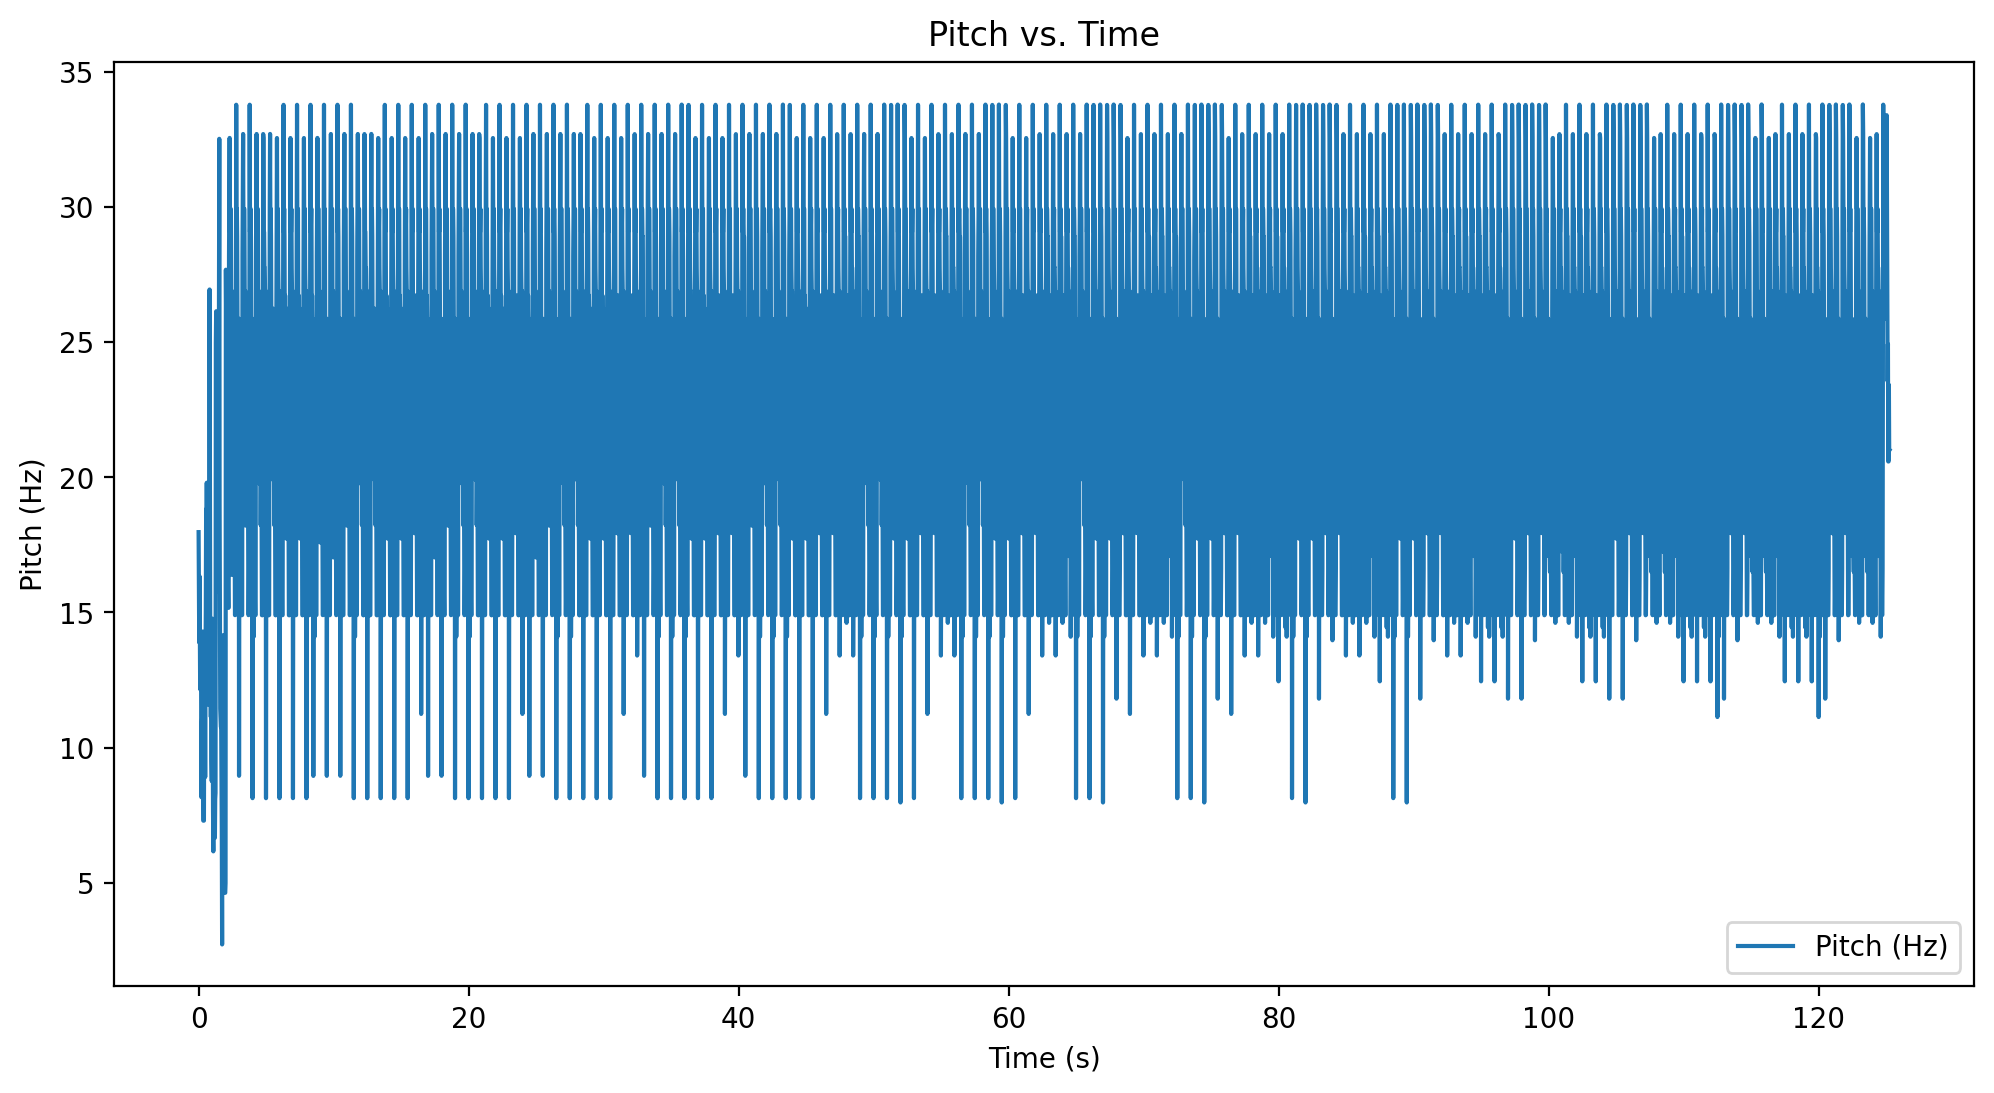

In [ ]:
plot_pitch_time("gdrive/MyDrive/Music Gen/test_output_trigram.wav")

In [ ]:
get_common_chord_progressions(prediction_output)

('4.10', '4.10', '4.10') 498 10

('4.10', '4.10', '4.10', '4.10') 497 7


# Fiftygram

Much better performing than bigram and trigram, improved graph and chord sequence matches, worse perplexity again because of increase in choices.

In [ ]:
fiftygrams = nltk.ngrams(notes, 50)
fiftygrams_count = nltk.FreqDist(fiftygrams)

fiftygrams_prev = nltk.ngrams(notes, 49)
fiftygrams_prev_count = nltk.FreqDist(fiftygrams_prev)

In [ ]:
fiftygram_model = {fiftygram: laplace_smooth(fiftygram, fiftygram_count, fiftygram[:-1], fiftygrams_prev_count) for fiftygram, fiftygram_count in fiftygrams_count.items()}

In [ ]:
start = random.choice(list(dict(fiftygrams_prev_count.items()).keys()))

pattern = [*start]
prediction_output = []

for note_index in range(500):
    candidates = [[fiftygram[-1], prob] for fiftygram, prob in fiftygram_model.items() if list(fiftygram[:-1]) == pattern]
    candidates = sorted(candidates, key=lambda candidate: candidate[1], reverse=True)
    if len(candidates) == 0:
        start = random.choice(list(dict(fiftygrams_prev_count.items()).keys()))
        pattern = [*start]
        result = pattern[-1]
    else:
        result = candidates[0][0]
    prediction_output.append(result)
    pattern.append(result)
    pattern = pattern[1:]

In [ ]:
offset = 0
output_notes = []

for pattern in prediction_output:
    if ("." in pattern) or (pattern.isdigit()):
        notes_in_chord = pattern.split('.')
        new_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            new_notes.append(new_note)
        new_chord = chord.Chord(new_notes)
        new_chord.offset = offset
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    offset += 0.5

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp="gdrive/MyDrive/Music Gen/test_output_fiftygram.mid")

'gdrive/MyDrive/Music Gen/test_output_fiftygram.mid'

In [ ]:
perplexity(notes, 50, dict(fiftygrams_count.items()))

0.7325662537217823

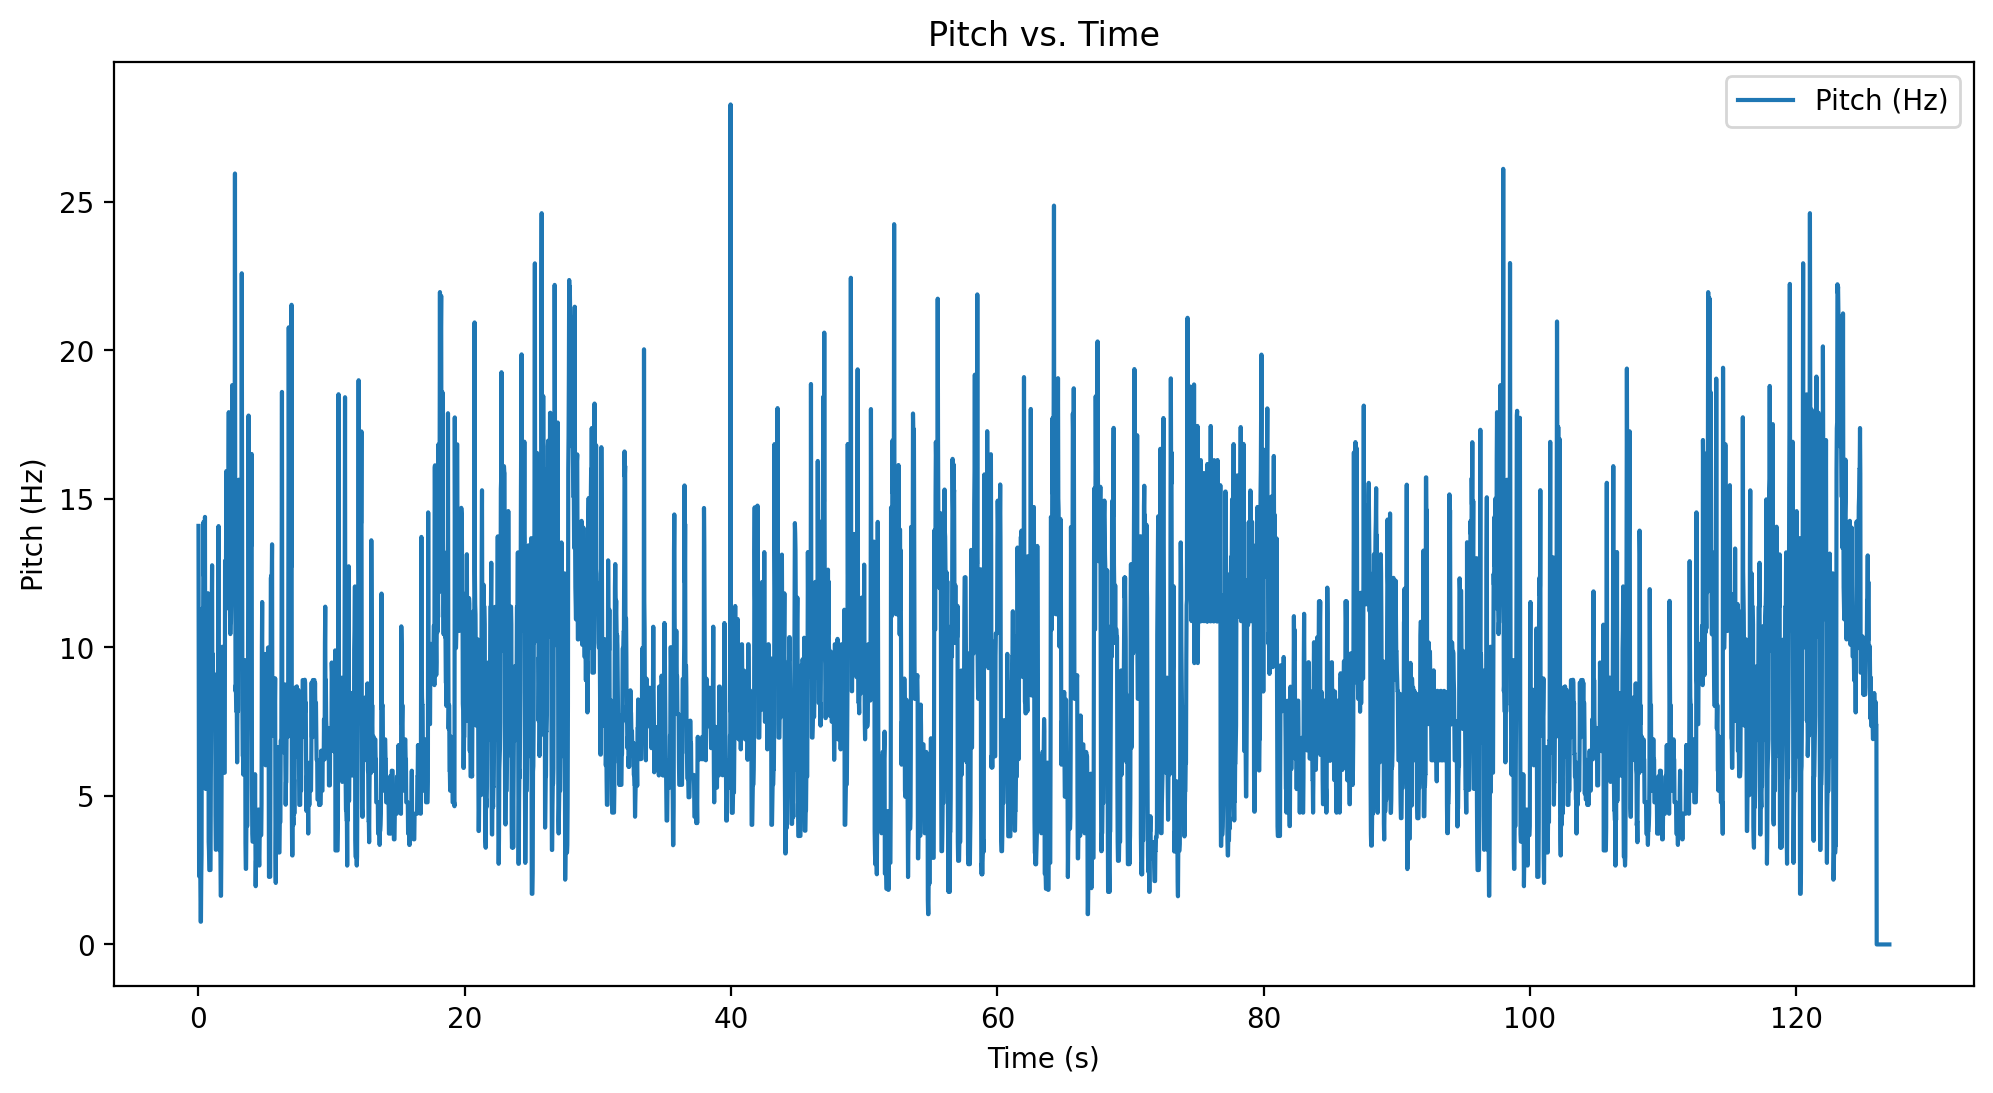

In [ ]:
plot_pitch_time("gdrive/MyDrive/Music Gen/test_output_fiftygram.wav")

In [ ]:
get_common_chord_progressions(prediction_output)

Unique three chord progressions: 39
Unique four chord progressions: 42

('11.2', '8.0', '7.11') 2 2
('8.0', '7.11', '6.10') 2 2
('7.11', '6.10', '7.11') 2 2
('6.10', '7.11', '8.0') 2 1
('7.11', '8.0', '3.8') 2 1
('8.0', '3.8', '0.3') 2 1
('3.8', '0.3', '3.8') 2 1
('0.3', '3.8', '7.11') 2 1
('3.8', '7.11', '7.11') 2 1
('7.11', '7.11', '1.6') 2 1
('7.11', '1.6', '10.1') 2 1
('1.6', '10.1', '1.6') 2 1
('10.1', '1.6', '7.11') 2 1
('1.6', '7.11', '0.3') 2 1
('7.11', '0.3', '10.2') 2 2
('0.3', '10.2', '8.0') 2 4
('10.2', '8.0', '7.11') 2 1
('8.0', '7.11', '5.8') 2 1
('7.11', '5.8', '7.0') 2 1
('5.8', '7.0', '9.0') 2 1
('7.0', '9.0', '7.11') 2 1
('9.0', '7.11', '2.8') 2 1
('7.11', '2.8', '1.7') 2 1
('2.8', '1.7', '0.6') 2 1
('1.7', '0.6', '0.3') 2 1
('0.6', '0.3', '11.2') 1 1
('0.3', '11.2', '10.1') 1 3
('11.2', '10.1', '9.0') 1 3
('10.1', '9.0', '0.3') 1 1
('9.0', '0.3', '9.0') 6 6
('0.3', '9.0', '0.3') 6 6
('9.0', '0.3', '8.11') 2 2
('0.3', '8.11', '11.2') 2 2
('8.11', '11.2', '8.11') 6 6
(

# Hundredgram

Best probabilistic n-gram model so far, much better graph and chord sequences, again worse perplexity due to choices increasing many fold.

In [ ]:
hundredgrams = nltk.ngrams(notes, 100)
hundredgrams_count = nltk.FreqDist(hundredgrams)

hundredgrams_prev = nltk.ngrams(notes, 99)
hundredgrams_prev_count = nltk.FreqDist(hundredgrams_prev)

In [ ]:
hundredgram_model = {hundredgram: laplace_smooth(hundredgram, hundredgram_count, hundredgram[:-1], hundredgrams_prev_count) for hundredgram, hundredgram_count in hundredgrams_count.items()}

In [ ]:
start = random.choice(list(dict(hundredgrams_prev_count.items()).keys()))

pattern = [*start]
prediction_output = []

for note_index in range(500):
    candidates = [[hundredgram[-1], prob] for hundredgram, prob in hundredgram_model.items() if list(hundredgram[:-1]) == pattern]
    candidates = sorted(candidates, key=lambda candidate: candidate[1], reverse=True)
    if len(candidates) == 0:
        start = random.choice(list(dict(hundredgrams_prev_count.items()).keys()))
        pattern = [*start]
        result = pattern[-1]
    else:
        result = candidates[0][0]
    prediction_output.append(result)
    pattern.append(result)
    pattern = pattern[1:]

In [ ]:
prediction_output

['5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '7',
 '7',
 '8',
 '8',
 '5.10',
 '10',
 '10',
 '0.4.7',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 'C6',
 '0',
 'G5',
 'E5',
 '0',
 'C5',
 'G5',
 '0',
 'E5',
 'C5',
 '0',
 'G4',
 'E5',
 '0',
 'C5',
 'G4',
 '0',
 'C4',
 '0.4.7',
 '0',
 '0',
 '2.6',
 '2',
 'A2',
 'E5',
 '2',
 'A2',
 '2.6.9',
 '2',
 '2.6',
 'A2',
 'C5',
 '2',
 'A2',
 '2.6',
 '2',
 'A2',
 'A4',
 '2',
 'A2',
 'G4',
 '2',
 'A2',
 '0.2.6',
 '2',
 'A2',
 '2.5',
 '2',
 'G#2',
 'E5',
 '2',
 'G#2',
 '2.5.8',
 '2',
 '2.5',
 'G#2',
 'C5',
 '2',
 'G#2',
 '2.5',
 '2',
 'G#2',
 'G#4',
 '2',
 'G#2',
 '7.0',
 '2',
 'G#2',
 '2.5',
 '2',
 'G#2',
 '0.4',
 '0',
 '0',
 '0',
 '0',
 '7',
 '0',
 '0',
 '0.4',
 '0',
 '0',
 '6.10',
 '6',
 '6',
 '4.8',
 '6',
 '6',
 '2.6',
 '6',
 '6',
 '1.6',
 '6',
 '6',
 '11.4',
 'F#5',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '9.0',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '7.11.2',
 '7',
 '7',
 '7',
 '7',
 'G5',
 '7',
 '7',
 'A3',
 '5',
 '5'

In [ ]:
offset = 0
output_notes = []

for pattern in prediction_output:
    if ("." in pattern) or (pattern.isdigit()):
        notes_in_chord = pattern.split('.')
        new_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            new_notes.append(new_note)
        new_chord = chord.Chord(new_notes)
        new_chord.offset = offset
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    offset += 0.5

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp="gdrive/MyDrive/Music Gen/test_output_hundredgram.mid")

'gdrive/MyDrive/Music Gen/test_output_hundredgram.mid'

In [ ]:
perplexity(notes, 100, dict(hundredgrams_count.items()))

0.8107748297532942

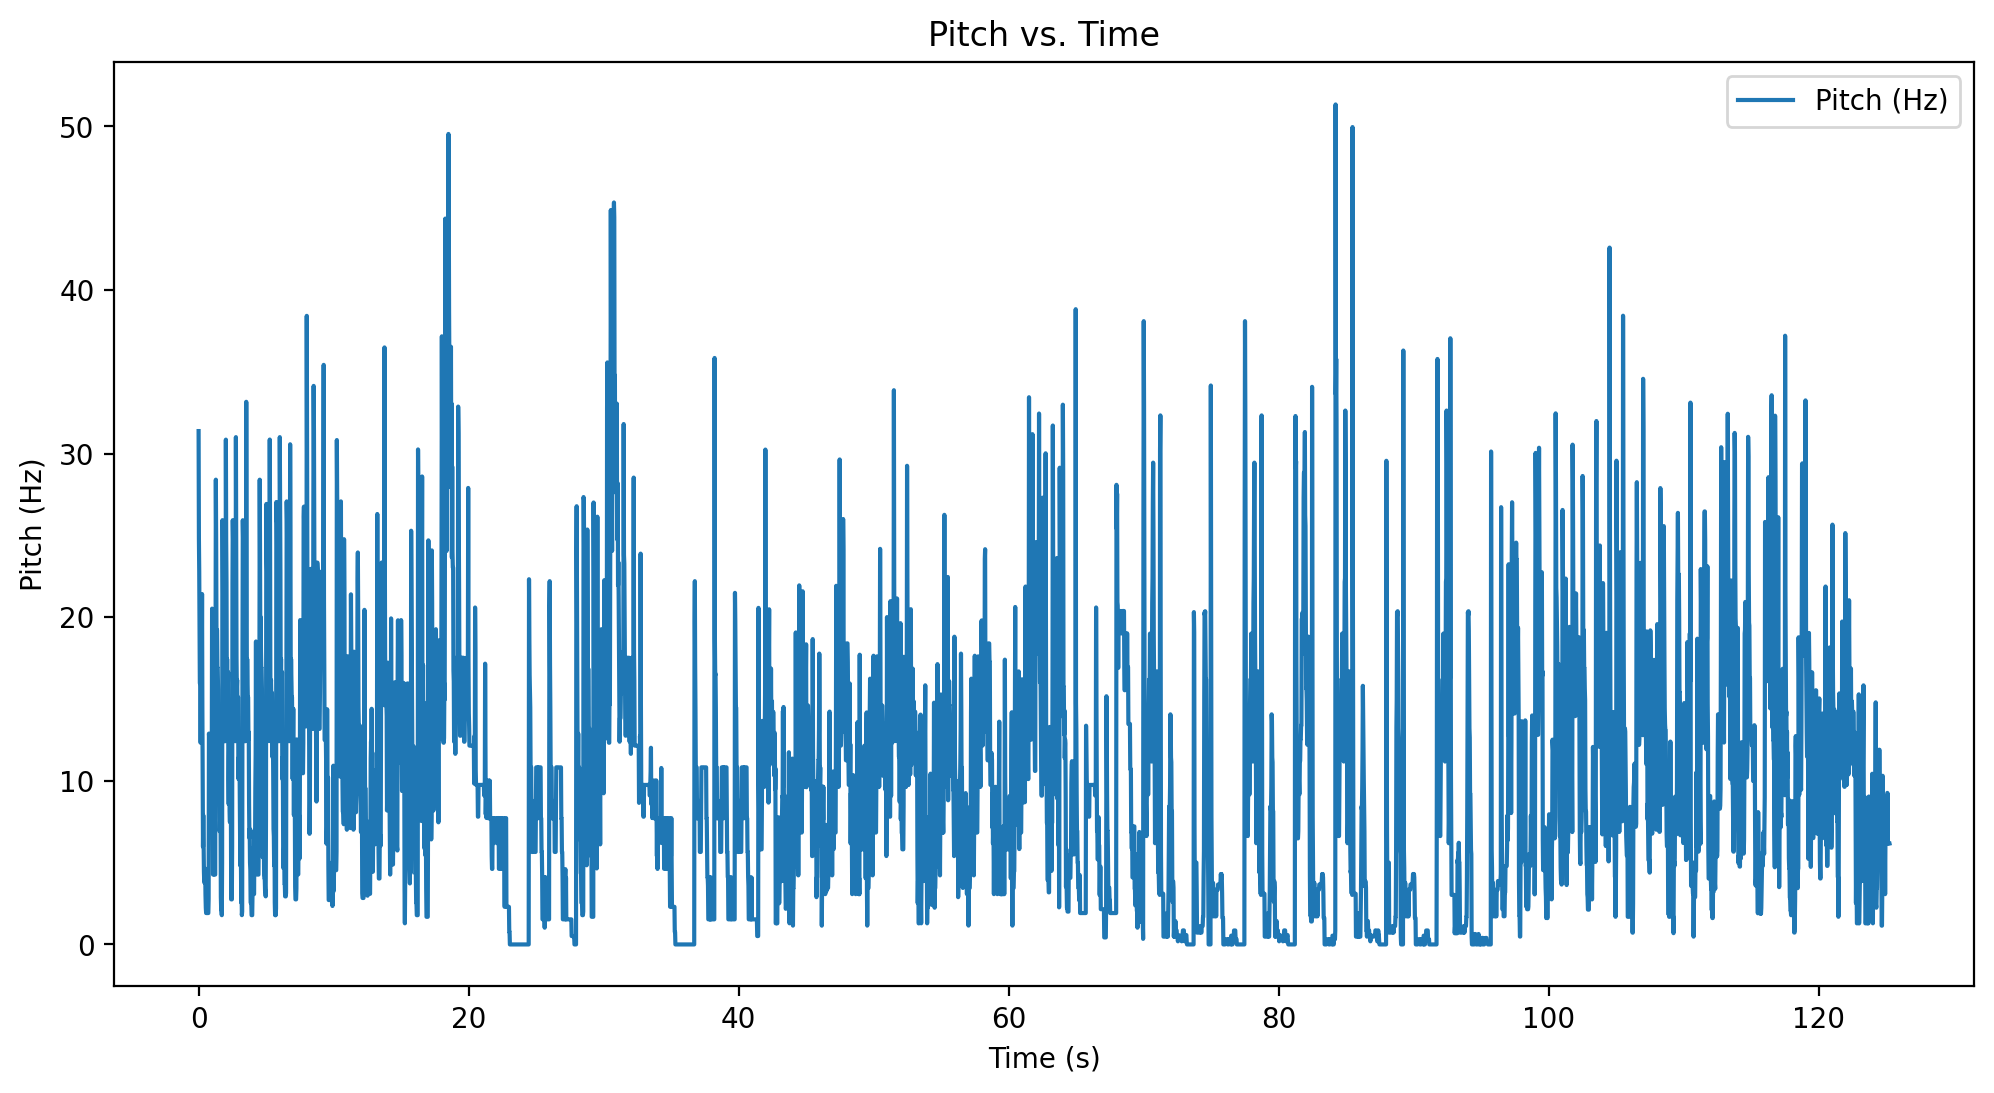

In [ ]:
plot_pitch_time("gdrive/MyDrive/Music Gen/test_output_hundredgram.wav")

In [ ]:
get_common_chord_progressions(prediction_output)

Unique three chord progressions: 86
Unique four chord progressions: 90
('2.5.8', '0.4.7', '4.9') 1 1
('0.4.7', '4.9', '9.0.4') 1 1
('4.9', '9.0.4', '9.0.4') 1 2
('9.0.4', '9.0.4', '0.4.7') 1 4
('9.0.4', '0.4.7', '6.9.0.2') 1 2
('0.4.7', '6.9.0.2', '5.9.0') 1 2
('6.9.0.2', '5.9.0', '5.9.0') 1 2
('5.9.0', '5.9.0', '9.0.4') 1 2
('5.9.0', '9.0.4', '0.4') 1 2
('9.0.4', '0.4', '9.0') 1 2
('0.4', '9.0', '0.4') 1 2
('9.0', '0.4', '10.2.5') 1 2
('0.4', '10.2.5', '2.5.8') 1 2
('10.2.5', '2.5.8', '2.4.8') 1 1
('2.5.8', '2.4.8', '2.3.7') 1 1
('2.4.8', '2.3.7', '2.3.7.10') 1 1
('2.3.7', '2.3.7.10', '9.0.2') 1 1
('2.3.7.10', '9.0.2', '7.11') 1 1
('9.0.2', '7.11', '11.2.4') 2 2
('7.11', '11.2.4', '9.0') 2 2
('11.2.4', '9.0', '9.0.2') 2 2
('9.0', '9.0.2', '7.11') 1 1
('9.0.2', '7.11', '7.11.0') 1 1
('7.11', '7.11.0', '7.9') 1 1
('7.11.0', '7.9', '9.0.2') 1 1
('7.9', '9.0.2', '7.11') 1 1
('9.0', '9.0.2', '0.3.6.9') 1 1
('9.0.2', '0.3.6.9', '11.2.4.7') 1 1
('0.3.6.9', '11.2.4.7', '7.11') 1 1
('11.2.4.7'

# LSTM

Using an LSTM based approach we get a model, that has stable graph along with almost identical chord sequences which is great.

In [ ]:
sequence_length = 100

pitchnames = sorted(set(item for item in notes))

n_vocab = len(set(notes))

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input_data = []
network_output = []

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]

    network_input_data.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input_data)

network_input = np.reshape(network_input_data, (n_patterns, sequence_length, 1))
network_input = network_input / float(n_vocab)

network_output = keras.utils.to_categorical(network_output)

In [ ]:
model = keras.Sequential([
    keras.layers.LSTM(512, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(512, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(512),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(n_vocab, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1052672   
                                                                 
 dropout (Dropout)           (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 512)          2099200   
                                                                 
 dropout_1 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
hist = model.fit(network_input, network_output, epochs=200, batch_size=64)

In [ ]:
model.load_weights("gdrive/MyDrive/Music Gen/weights.hdf5")

In [ ]:
start = np.random.randint(0, len(network_input) - 1)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = network_input_data[start]
prediction_output = []

for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)

    prediction = model.predict(prediction_input, verbose=0)

    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]

In [ ]:
offset = 0
output_notes = []

for pattern in prediction_output:
    if ("." in pattern) or (pattern.isdigit()):
        notes_in_chord = pattern.split('.')
        new_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            new_notes.append(new_note)
        new_chord = chord.Chord(new_notes)
        new_chord.offset = offset
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    offset += 0.5

In [ ]:
midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp="gdrive/MyDrive/Music Gen/test_output_lstm.mid")

'gdrive/MyDrive/Music Gen/test_output.mid'

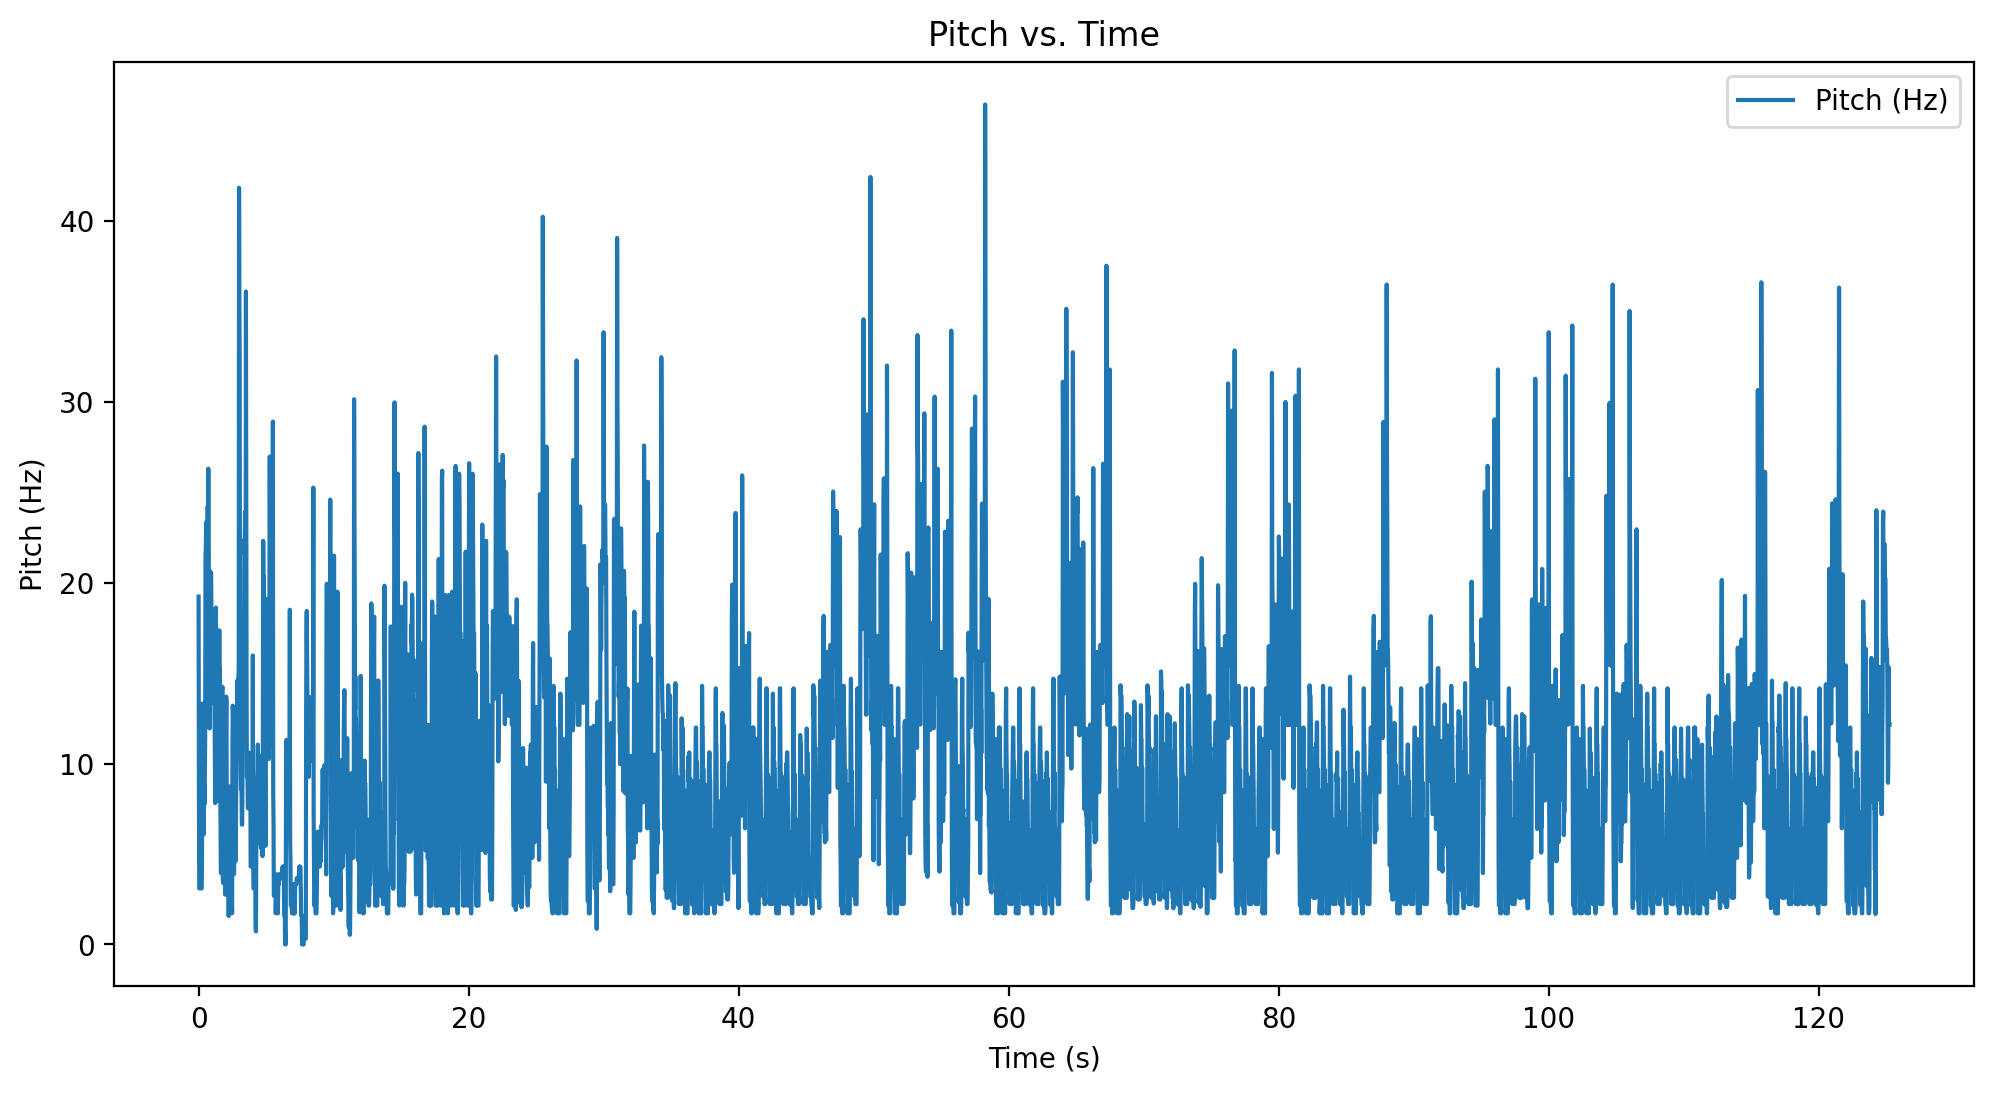

In [ ]:
plot_pitch_time("gdrive/MyDrive/Music Gen/test_output_lstm.wav")

In [ ]:
get_common_chord_progressions(prediction_output)